<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/DLthon/CIFAR10_VGG_%EC%A0%84%EC%9D%B4%EB%AA%A8%EB%8D%B8_GlobalAveragePooling2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1. EDA
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [2]:
# CIFAR-10 클래스 이름
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [3]:
# 2. 데이터 전처리
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [4]:
from tensorflow.keras.utils import to_categorical
# 클래스 레이블을 원핫인코딩으로 변환
num_classes = 10  # CIFAR-10은 10개의 클래스로 구성됨
train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

print(train_labels_one_hot)
print(test_labels_one_hot)

#원핫인코딩시켰기 때문에 loss를 categorical_crossentropy로 바꿔주어야 함
# not sparse_categorical_crossentropy

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [5]:
# 4. 이미지 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=15,       # 이미지 회전 범위 (도)
    width_shift_range=0.1,  # 수평 방향으로 이동 범위 (전체 너비의 비율)
    height_shift_range=0.1, # 수직 방향으로 이동 범위 (전체 높이의 비율)
    shear_range=0.1,        # 전단 변환 범위
    zoom_range=0.1,         # 확대/축소 범위
    horizontal_flip=True,   # 수평 방향으로 뒤집기
    fill_mode='nearest'     # 빈 공간을 어떻게 채울지 ('nearest', 'constant', 'reflect', 'wrap' 중 선택)
)
# datagen.fit(train_images)

In [6]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os

# 로그 디렉터리 설정
log_dir = "./logs"
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint('cifar10_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95  # decrease the learning rate after 10 epochs

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for our specific task
x = base_model.output
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)  # Replaced Flatten with GlobalAveragePooling2D

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

predictions = Dense(10, activation='softmax')(x)  # Assuming 10 classes for our new dataset

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# Compile and train the model (assuming you have train_data and train_labels)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [checkpoint, early_stopping, lr_scheduler]

# history = model.fit(datagen.flow(train_images, train_labels_one_hot, batch_size=32),
history = model.fit(train_images, train_labels_one_hot, batch_size=32,
                    epochs=20,
                    validation_data=(test_images, test_labels_one_hot),
                    shuffle=True,
                    callbacks=callbacks_list)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

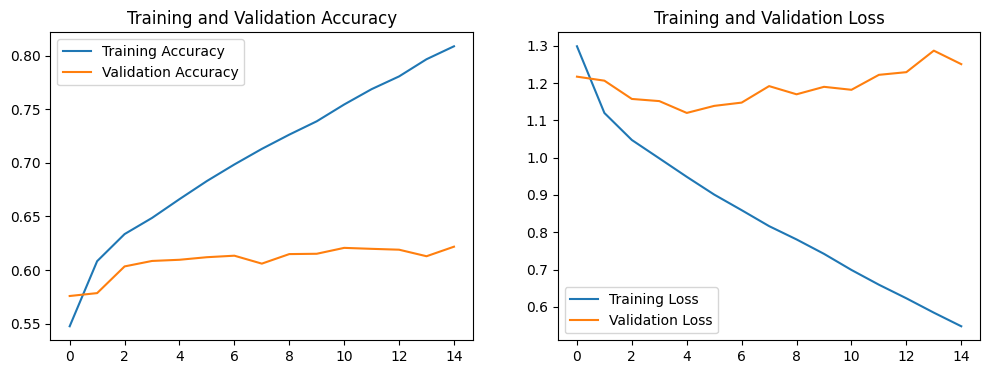

In [9]:
# 학습 및 검증 정확도와 손실을 그래프로 표시
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# 모델 학습 이후에 이 함수를 호출
plot_history(history)

313/313 [==============================] - 3s 7ms/step


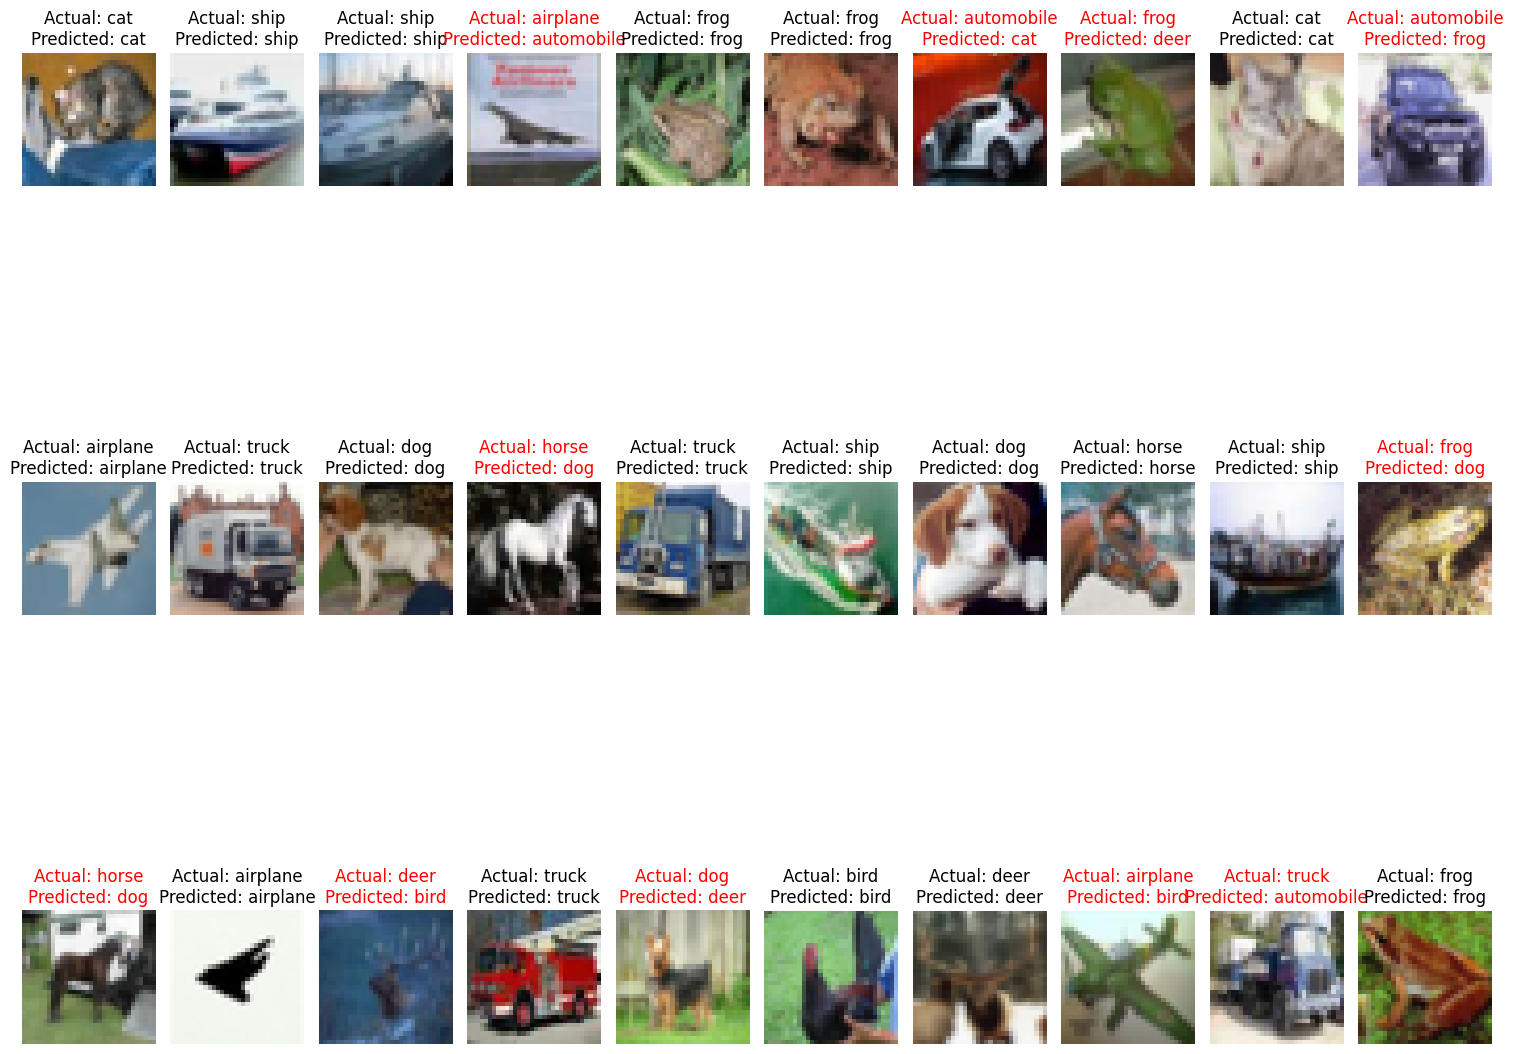

In [10]:
# 모델을 사용하여 예측한 클래스와 실제 클래스를 비교하는 이미지 시각화
def plot_predictions(images, labels, predictions, class_names, num=30, images_per_row=10):
    num_rows = (num + images_per_row - 1) // images_per_row
    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(num):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[i])

        actual_class = class_names[labels[i][0]]
        predicted_class = class_names[np.argmax(predictions[i])]

        title = f"Actual: {actual_class}\nPredicted: {predicted_class}"
        if actual_class != predicted_class:
            title = f"Actual: {actual_class}\nPredicted: {predicted_class}"
            plt.title(title, color='red')  # 예측이 틀린 경우 빨간색 글자로 표시
        else:
            plt.title(title)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 모델을 사용하여 예측
predictions = model.predict(test_images)

# 첫 30개 이미지에 대한 실제 클래스와 예측 클래스 시각화
plot_predictions(test_images, test_labels, predictions, class_names, num=30, images_per_row=10)
